In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
import os
import pickle

%load_ext autoreload
%autoreload 2

In [2]:
env = gym.make('MountainCar-v0', render_mode="human")

In [3]:
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

Action space: Discrete(3)
Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


In [4]:
starting_state, _ = env.reset() 

print(f"Starting state: {starting_state}")

Starting state: [-0.5782474  0.       ]


In [46]:
class DynaAgent():
    def __init__(self,env,size_bin_x=0.025,size_bin_y=0.005,epsilon_start=0.9,epsilon_end=0.05,alpha=0.1,gamma=0.99,k=5):
        self.env = env
        
        self.n_bins_x = int((env.observation_space.high[0]-env.observation_space.low[0])/size_bin_x)
        # print(f"Number of bins in x: {self.n_bins_x}")
        # print((env.observation_space.high[0]-env.observation_space.low[0])/size_bin_x)
        assert (env.observation_space.high[0]-env.observation_space.low[0])/size_bin_x-self.n_bins_x<1e-5 , "size_bin_x is not a divisor of the range of the x axis"
        self.n_bins_y= int((env.observation_space.high[1]-env.observation_space.low[1])/size_bin_y)
        assert (env.observation_space.high[1]-env.observation_space.low[1])/size_bin_y-self.n_bins_y<1e-5 , "size_bin_y is not a divisor of the range of the y axis"
        self.disc_step=np.array([size_bin_x,size_bin_y])
        self.x_bins = np.linspace(env.observation_space.low[0],env.observation_space.high[0],self.n_bins_x+1)
        self.y_bins= np.linspace(env.observation_space.low[1],env.observation_space.high[1],self.n_bins_y+1)
        
    
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.alpha = alpha
        self.gamma = gamma
        self.k=k
        self.n_states= (self.n_bins_x+1)*(self.n_bins_y+1)
        self.counts_total=np.zeros((self.n_states,3))
        self.counts_transition=np.zeros((self.n_states,3,self.n_states))
        self.P=np.ones((self.n_states,3,self.n_states))*1/self.n_states
        self.R=np.zeros((self.n_states,3))
        self.Q=np.zeros((self.n_states,3))
        self.model = {}
        self.last_reward_step=0
        self.timesteps_per_reward=[]
        
        self.state_action_pairs_encontered = []
        
        self.state=self.discretize_position(env.reset()[0])
    def discretize_position(self,position):
        # if np.digitize(position[0],self.x_bins)*np.digitize(position[1],self.y_bins)+np.digitize(position[1],self.y_bins)>=2016:
        #     print(np.digitize(position[0],self.x_bins)*np.digitize(position[1],self.y_bins)+np.digitize(position[1],self.y_bins))
        #     raise ValueError(f"position: {position} is out of bounds")
        return np.digitize(position[0],self.x_bins)+np.digitize(position[1],self.y_bins)*(self.n_bins_x+1)
    
    def update_P(self,state,action,next_state):
        self.counts_total[state,action]+=1
        self.counts_transition[state,action,next_state]+=1
        self.P[state,action,next_state]=self.P[state,action,next_state]+self.counts_transition[state,action,next_state]/(1+self.counts_total[state,action])
        self.P[state,action]/=np.sum(self.P[state,action])
        pass
    
    def update_R(self,state,action,reward):
        self.R[state,action] = (self.R[state,action]*(self.counts_total[state,action]-1)+reward)/self.counts_total[state,action]
        pass
    
    def update_Q(self,state,action):
        self.Q[state][action]=self.R[state,action]+self.gamma*np.sum(self.P[state,action]*np.max(self.Q,axis=1))
        pass
        
    def update_step(self,epsilon):
        state=self.state
        if np.random.rand()<epsilon:
            action = np.random.choice([0,1,2])
        else:
            action = np.argmax(self.Q[state])
        self.state_action_pairs_encontered.append((state,action))
            
        next_state, reward, done, _ ,_= self.env.step(action)
        #print(next_state)
        next_state=self.discretize_position(next_state)
        #self.Q[state][action] += self.alpha*(reward+self.gamma*np.max(self.Q[next_state])-self.Q[state][action])# TO DOOOOOOOOOOOOOOto be changeddddddd
        self.update_P(state,action,next_state)
        self.update_R(state,action,reward)
        #self.Q[state][action] = self.Q[state][action]+self.alpha*(reward+self.gamma*np.max(self.Q[next_state])-self.Q[state][action])
        self.update_Q(state,action)
        
        self.state=next_state
        
        for planning_step in range(self.k):
            state,action = self.state_action_pairs_encontered[np.random.choice(len(self.state_action_pairs_encontered))]
            reward = self.R[state,action]
            self.Q[state][action] =reward+self.gamma*np.sum(self.P[state,action]*np.max(self.Q,axis=1))#TO DOOOOOOOOOOOOOOOOOOOOOOOto be chnageddddddddddddddd
        
        return done
    
    def training(self,n_steps,reset=True):
        print("Training...")
        if reset:
            self.state=self.discretize_position(env.reset()[0])
        else:
            pass
        epsilon = self.epsilon_start
        
        
        for i in tqdm(range(n_steps)):
            done=self.update_step(epsilon)
            if done:
                print(f"Episode finished after {i} timesteps")
                self.timesteps_per_reward.append((i,i-self.last_reward_step))
                self.last_reward_step=i
                self.state=self.discretize_position(env.reset()[0])
            #epsilon exponential decay:
            epsilon = self.epsilon_end+(self.epsilon_start-self.epsilon_end)*np.exp(-i/1000)
            # if i%1000==0:
            #     print(np.max(self.Q))
            
        pass
    
    
    def inference(self,max_steps):
        frames=[]
        state=self.discretize_position(self.env.reset()[0])
        tot_reward=0
        frames.append(self.env.render(mode="rgb_array"))
        self.env.render()
        for i in tqdm(range(max_steps)):
            action = np.argmax(self.Q[state])
            next_state, reward, done, _ ,_= self.env.step(action)
            next_state=self.discretize_position(next_state)
            frames.append(self.env.render(mode="rgb_array"))
            tot_reward+=reward
            state=next_state
            if done:
                print(f"Episode finished after {i} timesteps")
                break
        print(f'total reward: {tot_reward}')
        return frames,tot_reward
    
    def save_agent(self,path):
        if not os.path.exists("agents_saved/"+path+"/"):
            os.makedirs("agents_saved/"+path+"/")
        path="agents_saved/"+path+"/"
        np.save(path+"_P.npy",self.P)
        np.save(path+"_Q.npy",self.Q)
        np.save(path+"_R.npy",self.R)
        #store it as pickle
        pickle.dump(self.state_action_pairs_encontered, open(path+"_state_action_pairs_encontered.pkl", 'wb'))
        np.save(path+"_counts_total.npy",self.counts_total)
        np.save(path+"_counts_transition.npy",self.counts_transition)
        pass
    
    def load_agent(self,path):
        path="agents_saved/"+path+"/"
        self.P=np.load(path+"_P.npy")
        self.Q=np.load(path+"_Q.npy")
        self.R=np.load(path+"_R.npy")
        #self.state_action_pairs_encontered=np.load(path+"_state_action_pairs_encontered.npy")
        with open(path+"_state_action_pairs_encontered.pkl", 'rb') as f:
            self.state_action_pairs_encontered = pickle.load(f)
        self.counts_total=np.load(path+"_counts_total.npy")
        self.counts_transition=np.load(path+"_counts_transition.npy")
        pass

In [47]:
env = gym.make('MountainCar-v0', render_mode="human")
dyna_agent=DynaAgent(env)


In [48]:
dyna_agent.training(30000,reset=True)

Training...


 31%|███       | 9284/30000 [05:26<12:21, 27.95it/s]  

Episode finished after 9279 timesteps


 45%|████▌     | 13543/30000 [07:49<10:01, 27.38it/s]

Episode finished after 13540 timesteps


 49%|████▉     | 14753/30000 [08:30<09:05, 27.95it/s]

Episode finished after 14749 timesteps


 52%|█████▏    | 15737/30000 [09:03<08:33, 27.78it/s]

Episode finished after 15733 timesteps


 56%|█████▌    | 16716/30000 [09:36<07:55, 27.95it/s]

Episode finished after 16712 timesteps


 60%|██████    | 18030/30000 [10:20<07:09, 27.84it/s]

Episode finished after 18024 timesteps


 62%|██████▏   | 18662/30000 [10:41<06:56, 27.25it/s]

Episode finished after 18659 timesteps


 64%|██████▍   | 19329/30000 [11:04<06:21, 27.99it/s]

Episode finished after 19325 timesteps


 68%|██████▊   | 20326/30000 [11:37<05:48, 27.78it/s]

Episode finished after 20322 timesteps


 70%|██████▉   | 20872/30000 [11:56<05:25, 28.04it/s]

Episode finished after 20866 timesteps


 72%|███████▏  | 21573/30000 [12:20<05:16, 26.60it/s]

Episode finished after 21571 timesteps


 77%|███████▋  | 23198/30000 [13:15<04:08, 27.35it/s]

Episode finished after 23196 timesteps


 84%|████████▍ | 25237/30000 [14:23<02:50, 27.99it/s]

Episode finished after 25232 timesteps


 87%|████████▋ | 26243/30000 [14:58<02:46, 22.52it/s]

Episode finished after 26239 timesteps


 89%|████████▉ | 26674/30000 [15:14<02:48, 19.68it/s]

Episode finished after 26673 timesteps


 91%|█████████ | 27179/30000 [15:31<01:40, 28.08it/s]

Episode finished after 27174 timesteps


 93%|█████████▎| 27962/30000 [15:57<01:12, 28.23it/s]

Episode finished after 27956 timesteps


 96%|█████████▋| 28948/30000 [16:30<00:37, 27.90it/s]

Episode finished after 28944 timesteps


 98%|█████████▊| 29414/30000 [16:46<00:21, 27.32it/s]

Episode finished after 29411 timesteps


100%|██████████| 30000/30000 [17:06<00:00, 29.24it/s]


In [49]:
dyna_agent.save_agent("dyna_agent0505-1116")

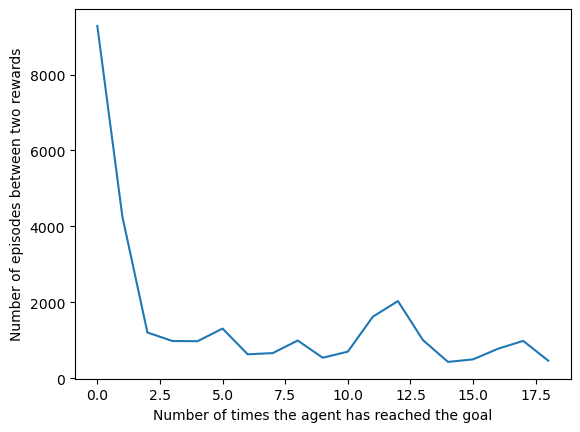

In [76]:
nb_episodes_per_reward=[duration[1] for duration in dyna_agent.timesteps_per_reward]
timesteps_reward=[duration[0] for duration in dyna_agent.timesteps_per_reward]
plt.plot(range(len(nb_episodes_per_reward)),nb_episodes_per_reward)
plt.xlabel("Number of times the agent has reached the goal")
plt.ylabel("Number of episodes between two rewards")
plt.savefig("plots/dyna/duration")
plt.show()

In [7]:
Q=np.load("agents_saved/dyna_agent1/dyna_agent1_Q.npy")

In [25]:
agent=DynaAgent(env)
agent.Q=Q
agent.n_bins_x=72
agent.n_bins_y=28

In [9]:
Q.shape

(2016, 3)

In [10]:
2016/28

72.0

In [14]:
Q[:,1]

array([0., 0., 0., ..., 0., 0., 0.])

In [74]:

def show_max_Q(agent):
    """Plot max Q value for each state
    Args:
        agent: An agent object with Q-values and state bins attributes
    """
    plt.figure(figsize=(10, 10))
    
    # Calculate max Q value per state and set zeros to NaN
    max_Q = agent.Q.max(axis=-1).copy()
    #max_Q[2000]=100
    max_Q=max_Q.reshape((agent.n_bins_y+1), (agent.n_bins_x+1))
    max_Q[max_Q == 0] = np.nan  # Replace zeros with NaN
    
    # Use imshow to plot, NaN values will not be displayed
    plt.imshow(max_Q, origin='lower', aspect='auto', cmap='viridis',extent=[-1.2, 0.6, -0.07, 0.07])  # Added cmap for better color handling
    plt.colorbar()
    plt.title("Max Q value (after 30 000 episodes)")
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.savefig("plots/dyna/max_q")
    plt.show()

In [57]:
dyna_agent.Q.shape

(2117, 3)

In [63]:
(1+dyna_agent.n_bins_x)* (1+dyna_agent.n_bins_y)

2117

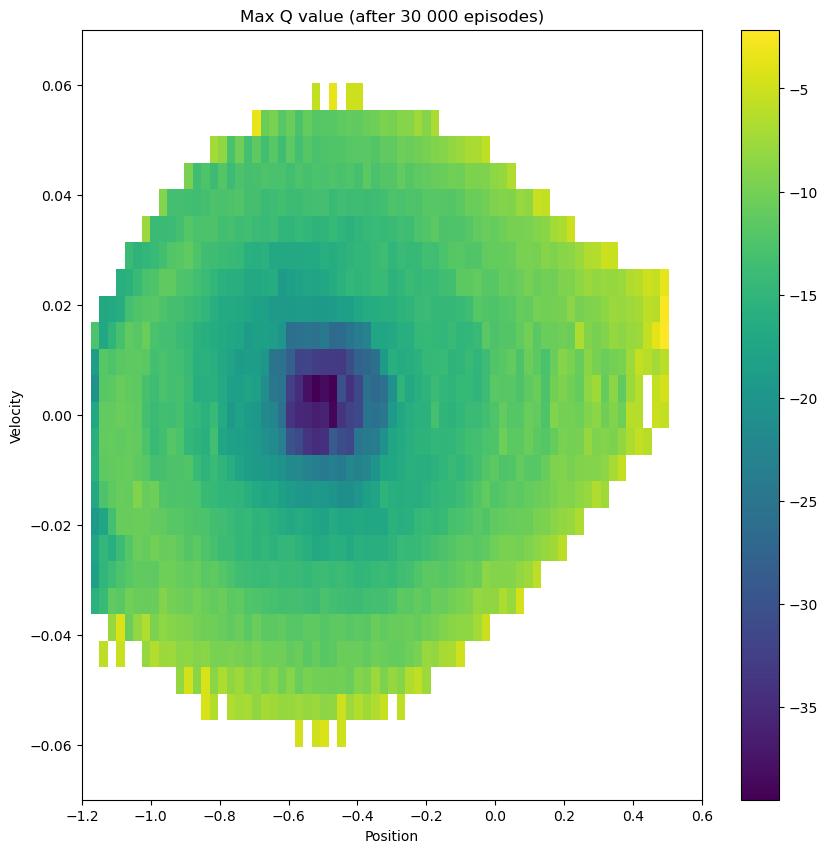

In [75]:
show_max_Q(dyna_agent)